In [91]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import IPython.display as ipyd
import vgg16
import utils
from tqdm import tqdm, tqdm_notebook
from pathlib2 import Path # pathlib2 is a built-in lib in Python 3, unfortunately is external in Python 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
vgg = vgg16.get_vgg_model()
tf.import_graph_def(vgg['graph_def'], name='vgg')
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
input_name = names[0] + ':0'
x = g.get_tensor_by_name(input_name)
output = g.get_tensor_by_name(names[-2] + ':0')

In [3]:
names

[u'vgg/images',
 u'vgg/mul/y',
 u'vgg/mul',
 u'vgg/split/split_dim',
 u'vgg/split',
 u'vgg/sub/y',
 u'vgg/sub',
 u'vgg/sub_1/y',
 u'vgg/sub_1',
 u'vgg/sub_2/y',
 u'vgg/sub_2',
 u'vgg/concat/concat_dim',
 u'vgg/concat',
 u'vgg/conv1_1/filter',
 u'vgg/conv1_1/Conv2D',
 u'vgg/conv1_1/biases',
 u'vgg/conv1_1/BiasAdd',
 u'vgg/conv1_1/conv1_1',
 u'vgg/conv1_2/filter',
 u'vgg/conv1_2/Conv2D',
 u'vgg/conv1_2/biases',
 u'vgg/conv1_2/BiasAdd',
 u'vgg/conv1_2/conv1_2',
 u'vgg/pool1',
 u'vgg/conv2_1/filter',
 u'vgg/conv2_1/Conv2D',
 u'vgg/conv2_1/biases',
 u'vgg/conv2_1/BiasAdd',
 u'vgg/conv2_1/conv2_1',
 u'vgg/conv2_2/filter',
 u'vgg/conv2_2/Conv2D',
 u'vgg/conv2_2/biases',
 u'vgg/conv2_2/BiasAdd',
 u'vgg/conv2_2/conv2_2',
 u'vgg/pool2',
 u'vgg/conv3_1/filter',
 u'vgg/conv3_1/Conv2D',
 u'vgg/conv3_1/biases',
 u'vgg/conv3_1/BiasAdd',
 u'vgg/conv3_1/conv3_1',
 u'vgg/conv3_2/filter',
 u'vgg/conv3_2/Conv2D',
 u'vgg/conv3_2/biases',
 u'vgg/conv3_2/BiasAdd',
 u'vgg/conv3_2/conv3_2',
 u'vgg/conv3_3/filt

In [64]:
op_types = {op.name: op.type for op in g.get_operations()}
conv_layers = [name for (name, type_) in op_types.items() if type_ == 'Conv2D']
relu_layers = [name for (name, type_) in op_types.items() if type_ == 'Relu']
pool_layers = [name for (name, type_) in op_types.items() if type_ == 'MaxPool']
print(conv_layers)
print(relu_layers)
print(pool_layers)

[u'vgg/conv2_1/Conv2D', u'vgg/conv5_3/Conv2D', u'vgg/conv2_2/Conv2D', u'vgg/conv4_3/Conv2D', u'vgg/conv4_2/Conv2D', u'vgg/conv1_1/Conv2D', u'vgg/conv1_2/Conv2D', u'vgg/conv5_1/Conv2D', u'vgg/conv3_2/Conv2D', u'vgg/conv4_1/Conv2D', u'vgg/conv5_2/Conv2D', u'vgg/conv3_3/Conv2D', u'vgg/conv3_1/Conv2D']
[u'vgg/conv5_1/conv5_1', u'vgg/conv2_2/conv2_2', u'vgg/conv2_1/conv2_1', u'vgg/conv5_2/conv5_2', u'vgg/conv1_2/conv1_2', u'vgg/conv5_3/conv5_3', u'vgg/conv4_2/conv4_2', u'vgg/conv3_2/conv3_2', u'vgg/conv4_3/conv4_3', u'vgg/fc7_relu', u'vgg/fc6_relu', u'vgg/conv1_1/conv1_1', u'vgg/conv3_1/conv3_1', u'vgg/conv3_3/conv3_3', u'vgg/conv4_1/conv4_1']
[u'vgg/pool2', u'vgg/pool3', u'vgg/pool1', u'vgg/pool4', u'vgg/pool5']


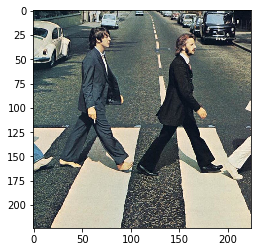

In [108]:
def load_image(img_path):
    img = vgg16.preprocess(plt.imread(img_path)[:, :, 0:3]) # the selection is needed to get rid of the alpha channel
    img_4d = img[np.newaxis]
    return img_4d

img = load_img('images/abbey_road.png')
plt.imshow(vgg16.deprocess(img.squeeze()))

In [68]:
def get_layer_depth(layer, feed_dict=None):
    if isinstance(layer, basestring):
        layer = g.get_tensor_by_name(layer)
    layer_shape = tf.Tensor.get_shape(layer)[-1]
    
    # If the shape of the tensor could not be statically determined then try to evaluate it dynamically if 
    # a feed_dict was passed, or raise an exception
    if layer_shape.value is None:
        if feed_dict is not None:
            layer_shape = tf.shape(layer).eval(feed_dict=feed_dict)[-1] # Avoid evaluating a full graph just to get a shape
        else:
            raise Exception("Layer depth can not be computed from the static graph, please pass a feed_dict to eval it. "
                            "(Are you sure you have passed a layer with a depth dimension?)")
    return layer_shape

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    depth = get_layer_depth('vgg/conv5_3/conv5_3:0')
    # depth = get_layer_depth('vgg/conv5_3/conv5_3:0', feed_dict={x: img})
    print(depth)

512


In [106]:
def add_no_droupout(feed_dict):
    feed_dict['vgg/dropout_1/random_uniform:0'] = [[1.0] * 4096]
    feed_dict['vgg/dropout/random_uniform:0'] = [[1.0] * 4096]
    return feed_dict

In [109]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    feed_dict = add_no_droupout({x: img})
    res = output.eval(feed_dict=feed_dict)[0]

print([(res[idx], vgg['labels'][idx])
       for idx in res.argsort()[-5:][::-1]])

[(0.99464899, (627, 'n03670208 limousine, limo')), (0.0044518975, (523, 'n03141823 crutch')), (0.00059714454, (879, 'n04507155 umbrella')), (8.6170694e-05, (612, 'n03599486 jinrikisha, ricksha, rickshaw')), (6.9687914e-05, (834, 'n04350905 suit, suit of clothes'))]


In [112]:
def compute_gradient(input_placeholder, img, layer_name, filter_i):
    layer = g.get_tensor_by_name(layer_name)
    gradient = tf.gradients(tf.reduce_mean(layer[:, :, :, filter_i]), x)
    res = sess.run(gradient, feed_dict=add_no_droupout({input_placeholder: img}))[0]
    return res

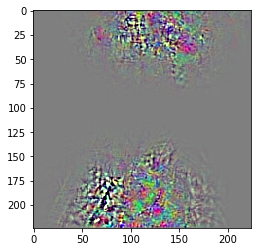

In [115]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    res = compute_gradient(x, img, 'vgg/conv5_3/conv5_3:0', 50)
res_n = utils.normalize(res[0])
plt.imshow(res_n)

In [116]:
def compute_gradients(input_placeholder, img, layer_name):
    depth = get_layer_depth(layer_name)
    gradients = []
    for neuron_i in range(depth):
        gradients.append(compute_gradient(input_placeholder, img, layer_name, neuron_i))
    return gradients

In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    gradients = compute_gradients(x, img, 'vgg/conv5_3/conv5_3:0')
gradients_norm = [normalize(gradient_i[0]) for gradient_i in gradients]
montage = utils.montage(np.array(gradients_norm))

In [119]:
images = [str(p.name) for p in Path('images').glob('*.png')]
print(images)
layers = relu_layers
print(layers)

df = pd.DataFrame(columns=['image', 'layer', 'filter', 'mean_activation'])
df.set_index(['image', 'layer', 'filter'], inplace=True)
#df.loc['test_img', 'layer1', 0] = 4
df

['aimotive_car.png', 'abbey_road.png']
[u'vgg/conv5_1/conv5_1', u'vgg/conv2_2/conv2_2', u'vgg/conv2_1/conv2_1', u'vgg/conv5_2/conv5_2', u'vgg/conv1_2/conv1_2', u'vgg/conv5_3/conv5_3', u'vgg/conv4_2/conv4_2', u'vgg/conv3_2/conv3_2', u'vgg/conv4_3/conv4_3', u'vgg/fc7_relu', u'vgg/fc6_relu', u'vgg/conv1_1/conv1_1', u'vgg/conv3_1/conv3_1', u'vgg/conv3_3/conv3_3', u'vgg/conv4_1/conv4_1']


,,,mean_activation
image,layer,filter,


In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for image_name in tqdm(images, desc='Images'):
        img = load_image('images/' + img_name)
        
        feed_dict = {x: img}

        for layer_name in tqdm(layers, desc='Layers'):
            layer_tensor_name = layer_name + ':0'
            layer = g.get_tensor_by_name(layer_tensor_name)
            print(layer)
            
            mean_activations = []
            #for filter_number in range(min(get_layer_depth(layer), 5)): # Max 5 filters for debugging
            for filter_number in range(get_layer_depth(layer)):
                # save the average activation of that filter
                if len(layer.shape) == 4:
                    mean_activation_op = tf.reduce_mean(layer[:, :, :, filter_number])
                elif len(layer.shape) == 2:
                    mean_activation_op = tf.reduce_mean(layer[:, filter_number])
                else:
                    raise Exception("Unknown layer type")
                mean_activations.append(mean_activation_op)
            mean_activations_val = sess.run(mean_activations, feed_dict={x: img})
            for filter_number, activation in enumerate(mean_activations_val):
                df.loc[img_name, layer_name, filter_number] = activation

In [ ]:
df.head()

In [104]:
df.to_csv('output/mean_activations.csv')